In [19]:
# This module handles the projection of a catalog on a specific grid
# Adapted from the DESC WLMASSMAP code.

import numpy as np
#from scipy.stats import binned_statistic_2d
import healpy as hp
from astropy.table import Table
from kaiser_squires import flat_KS_map, healpix_KS_map
import matplotlib.pyplot as plt
import pandas as pd
# pixel resolution:
Nside=1024

#smoothing of the kappa maps, in arcmin:
sigma = 2.0

patch='N'

path1='/global/cfs/cdirs/lsst/groups/WL/projects/wl-massmap/IA-infusion/BCM/dmb/GalCat/GalCat_tomo3_All_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc'
ascii_grid = np.loadtxt(path1)
## RA_Dec_g1_g2_w_z
## shape=11135611, 6
z=ascii_grid[:,-1]
w=ascii_grid[:,-2]
g2=ascii_grid[:,-3]
g1=ascii_grid[:,-4]
dec1=ascii_grid[:,-5]
ra1=ascii_grid[:,0]


catalog={'ra': ra1, 'dec':dec1,'shear1': g1, 'shear2': g2,'w':w,'z':z}
file = pd.DataFrame(catalog)
file.to_csv('hacc_catalog.csv', index=False)

def eq2ang(ra, dec):
    """
    convert equatorial ra,dec in degrees to angular theta, phi in radians
    parameters

    ----------
    ra: scalar or array
        Right ascension in degrees
    dec: scalar or array
        Declination in degrees
    returns
    -------
    theta,phi: tuple
        theta = pi/2-dec*D2R # in [0,pi]
        phi   = ra*D2R       # in [0,2*pi]
    """
    dec = dec*np.pi/180
    ra  = ra*np.pi/180
    theta = np.pi/2 - dec
    phi  = ra
    return theta, phi

def project_healpix(catalog, nside, hp_type='RING'):
    """
    Adds a HEALpix pixel index to all galaxies in the catalog

    Parameters
    ----------
    catalog: table
        Input shape catalog

    nside: int
        HEALpix nside parameter

    hp_type: string
        HEALpix pixel order ('RING', 'NESTED')

    Returns
    -------
    catalog: table
        Output shape catalog with pixel index column
        nest will be either True or False depending on input
    """
    theta, phi = eq2ang(catalog['ra'], catalog['dec'])
    catalog['pixel_index'] = hp.ang2pix(nside, theta, phi,
                                        nest=(hp_type=='NESTED'))
    return catalog

def bin_shear_map(catalog, nx=None, ny=None, npix=None, seed_id=None):
    """
    Computes the shear map by binning the catalog according to pixel_index.
    Either nx,ny or npix must be provided.
    
    Parameters
    ----------
    catalog: table
        Input shape catalog with pixel_index column

    nx,ny: int, optional
        Number of pixels of a 2d flat map
    
    npix: int, optional
        Number of pixels of a spherical map (or other 1D pixelating scheme)

    sigtype: type of observations 
        GG_noisefree    = cosmic shear noise-free
        GG_IA_noisefree = cosmic shear noise-free + IA
        GG_IA_noisy     = cosmic shear + IA + shapenoise
        pureIA          = pure IA 
        
    Returns
    -------
    gmap: ndarray
        Shear maps

    nmap: ndarray
        Number of galaxies per pixels
    """
    assert (npix is not None) or ((nx is not None) and (ny is not None))

    # Bin the shear catalog
    if npix is None:
        npix = nx*ny

    str1 = 'shear1';str2 = 'shear2'

        
    #HACC/OuterRim:
    g1map = np.bincount(catalog['pixel_index'],
                        weights=catalog[str1],
                        minlength=npix)
    g2map = np.bincount(catalog['pixel_index'],
                        weights=catalog[str2],
                        minlength=npix)
    Nmap  = np.bincount(catalog['pixel_index'], minlength=npix)
    


    # Normalize by number of galaxies
    nz_ind = Nmap > 0
    g1map[nz_ind] /= Nmap[nz_ind]
    g2map[nz_ind] /= Nmap[nz_ind]

    gmap = np.stack([g1map,g2map], axis=0)

    return gmap, Nmap





In [32]:


print('got catalogue') 
    
    # Add pixel ID to the catalogue, to be used in healpix projection:
file = project_healpix(file, nside=Nside)
    

gmap, nmap = bin_shear_map(file, npix=hp.nside2npix(Nside))

print('got shear maps') 

kappa_e, kappa_b = healpix_KS_map(gmap, lmax = Nside, sigma=sigma)

got catalogue
got shear maps


/pscratch/sd/d/dgrandon/LSST/massmap/kaiser_squires.py:53: RuntimeWarning: divide by zero encountered in divide
  almsE = alms[1]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
/pscratch/sd/d/dgrandon/LSST/massmap/kaiser_squires.py:53: RuntimeWarning: invalid value encountered in multiply
  almsE = alms[1]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
/pscratch/sd/d/dgrandon/LSST/massmap/kaiser_squires.py:54: RuntimeWarning: divide by zero encountered in divide
  almsB = alms[2]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
/pscratch/sd/d/dgrandon/LSST/massmap/kaiser_squires.py:54: RuntimeWarning: invalid value encountered in multiply
  almsB = alms[2]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
/pscratch/sd/d/dgrandon/LSST/massmap/kaiser_squires.py:60: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  E_map = hp.alm2map(almsE, nside=nside, lmax=lmax, pol=False, sigma=sigma, verbose=False)
/pscratch/sd/d/dgrandon/LSST/massmap/kaiser_squires.p

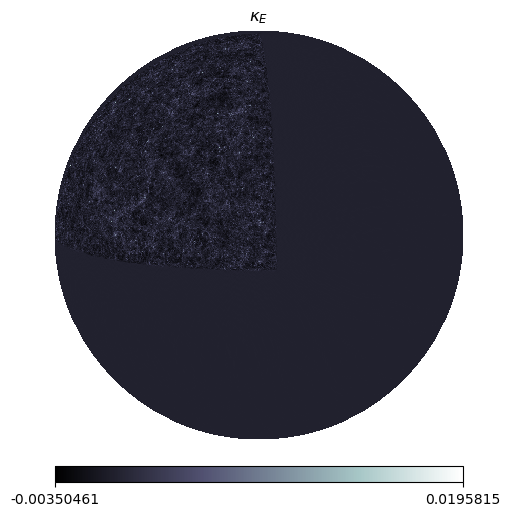

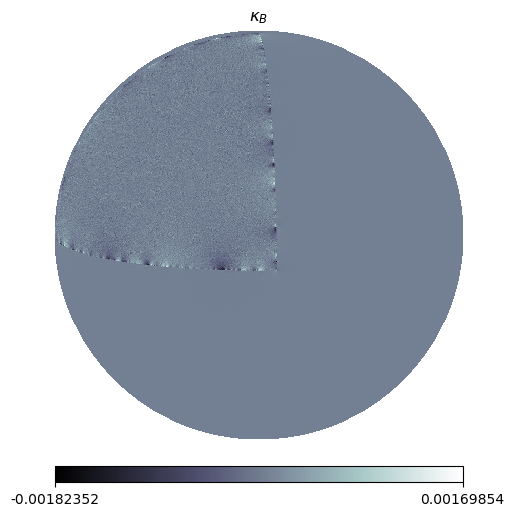

In [33]:
hp.orthview(kappa_e,rot=(5,10),
                half_sky=True,
                title = "$\kappa_{E}$",
                cmap='bone',
            
               )
hp.orthview(kappa_b,rot=(5,10),
                half_sky=True,
                title = "$\kappa_{B}$",
                cmap='bone',
            
               )

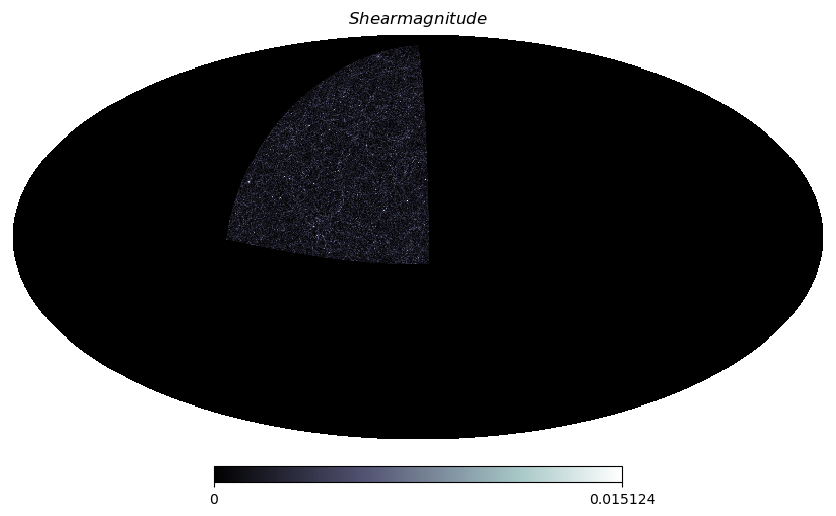

In [34]:
hp.mollview(np.sqrt(gmap[0,:]**2 + gmap[1,:]**2),rot=(5,10),
                title = "$Shear magnitude$",
                cmap='bone',
            
               )

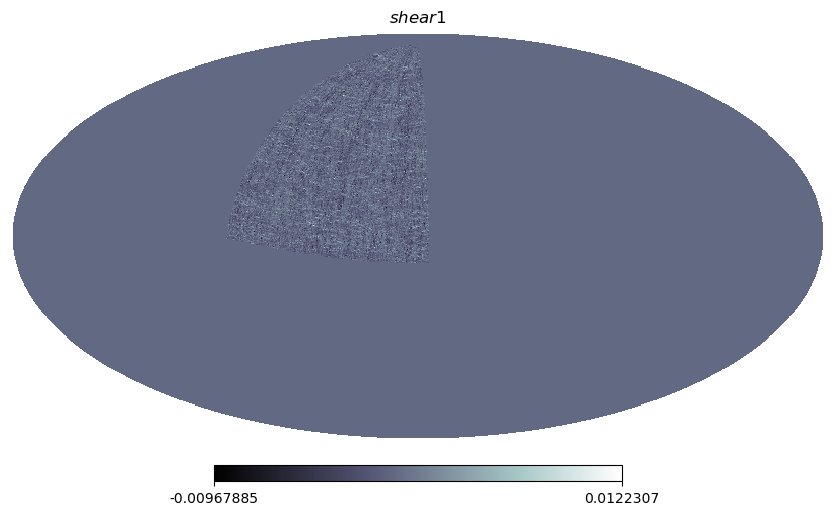

In [35]:
hp.mollview(gmap[0,:],rot=(5,10),
                title = "$shear 1$",
                cmap='bone',
            
               )

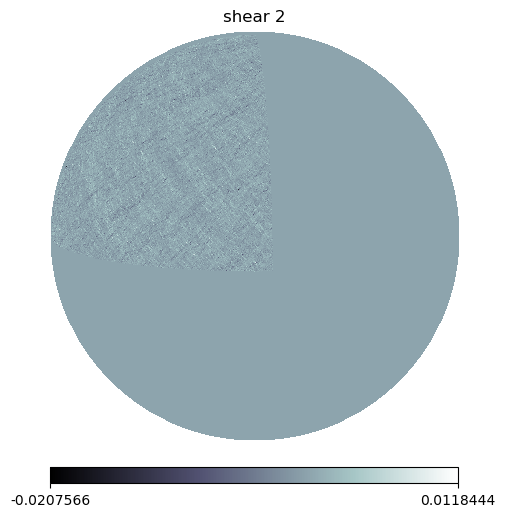

In [36]:
hp.orthview(gmap[1,:],rot=(5,10),
                half_sky=True,
                title = "shear 2",
                cmap='bone',
            
               )

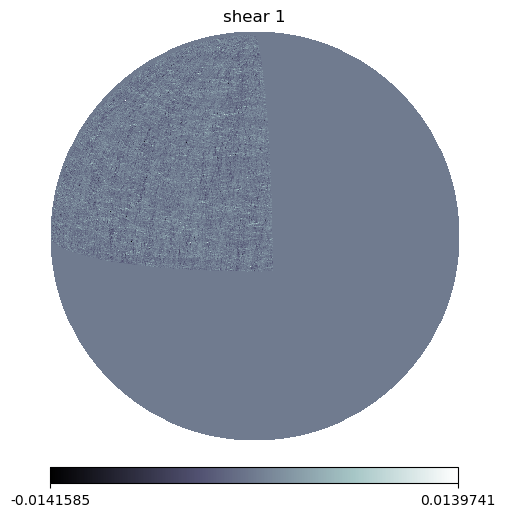

In [37]:
hp.orthview(gmap[0,:],rot=(5,10),
                half_sky=True,
                title = "shear 1",
                cmap='bone',
            
               )